# Import niezbędnych bibliotek

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from keras.models import Sequential    
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model

from prophet import Prophet
import pmdarima as pm

%matplotlib inline

sns.set_style('darkgrid')
default_fig_size = (14,12)

# Wczytanie danych i przygotowanie ich do odpowiedniego formatu

In [65]:
df = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)
df.index = df.index.map(datetime.toordinal) # zamiana daty na liczby całkowite

stocks = {}
for col in df.columns:
    stocks[col] = df[[col]]

stocks['AAPL']

AAPL
Date              
735008   13.733949
735009   13.632556
735010   13.684957
735011   13.709449
735012   13.802786
...            ...
738650  173.320267
738651  173.510010
738652  172.570007
738655  172.070007
738656  172.070007

[2516 rows x 1 columns]

# Podział na zbiór treningowy i testowy

In [105]:
# NYSE i NASDAQ - około 252 dni w roku, kiedy giełda jest otwarta - https://sortter.com/blog/article/how-many-trading-days-in-a-year/
df_without_ordinal = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df_without_ordinal.index = pd.to_datetime(df_without_ordinal.index)

stocks_without_ordinal = {}
for col in df_without_ordinal.columns:
    stocks_without_ordinal[col] = df_without_ordinal[[col]]


last_5_years = 252*5
last_year = 252

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'].index, stocks_without_ordinal['AAPL'].values, test_size=test_size, shuffle=False)
print('Dla ostatnich 10 lat:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'][-last_5_years:].index, stocks_without_ordinal['AAPL'][-last_5_years:].values, test_size=test_size, shuffle=False)
print('\nDla ostatnich 5 lat:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'][-last_year:].index, stocks_without_ordinal['AAPL'][-last_year:].values, test_size=test_size, shuffle=False)
print('\nDla ostatniego roku:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

Dla ostatnich 10 lat:
Rozmiar zbioru treningowego: 2012 | Pierwsza data: 2013-05-20
Rozmiar zbioru testowego: 504 | Pierwsza data: 2021-05-17
Ostatnia data zbioru testowego: 2023-05-16

Dla ostatnich 5 lat:
Rozmiar zbioru treningowego: 1008 | Pierwsza data: 2018-05-15
Rozmiar zbioru testowego: 252 | Pierwsza data: 2022-05-16
Ostatnia data zbioru testowego: 2023-05-16

Dla ostatniego roku:
Rozmiar zbioru treningowego: 201 | Pierwsza data: 2022-05-16
Rozmiar zbioru testowego: 51 | Pierwsza data: 2023-03-06
Ostatnia data zbioru testowego: 2023-05-16


# Funkcje pomocnicze

In [67]:
def evaluate_model(y_test, y_pred):
    r2 = np.round(r2_score(y_test, y_pred), 2)
    mse = np.round(mean_squared_error(y_test, y_pred), 2)
    mae = np.round(mean_absolute_error(y_test, y_pred), 2)

    df = pd.DataFrame(data=[r2, mse, mae], index=['R2', 'MSE', 'MAE'], columns=['Wartość'])
    return df

# Regresja liniowa

In [61]:
def linear_regression_model(data, ax):
        X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_pred = lr.predict(X_test)

        ax.plot(X_train, y_train, label='train')
        ax.plot(X_train, y_train_pred, label='train pred')
        ax.plot(X_test, y_test, label='test')
        ax.plot(X_test, y_pred, label='pred')
        ax.legend(loc=2)
        ax.set_title(stock)

        results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

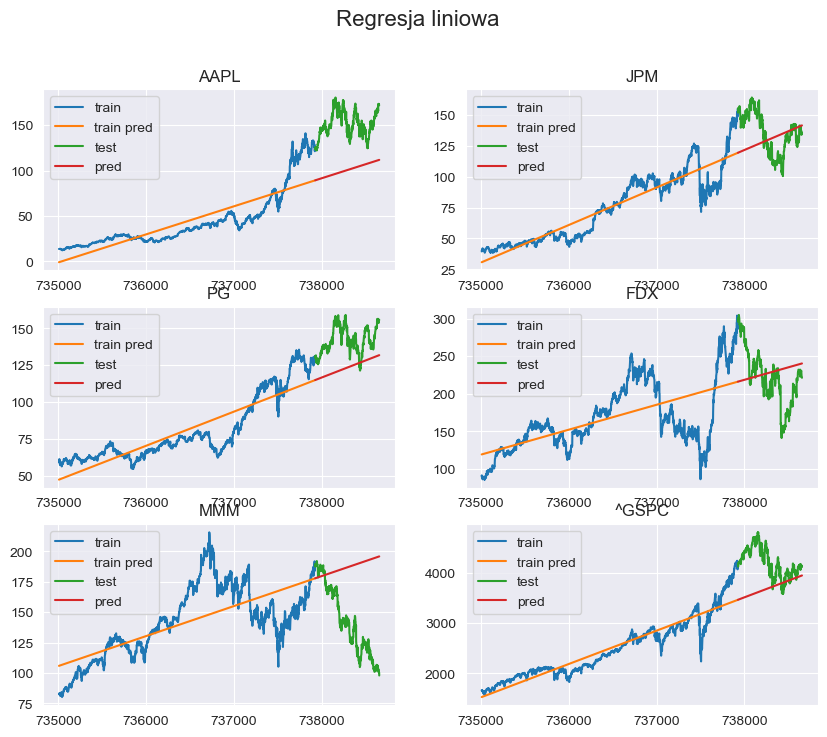

AAPL     JPM      PG      FDX      MMM      ^GSPC
R2    -14.31   -0.71   -4.43    -0.35    -2.89      -3.88
MSE  2794.66  436.60  423.30  1756.17  2984.88  405532.21
MAE    51.00   17.47   18.74    33.05    45.72     513.96

In [62]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

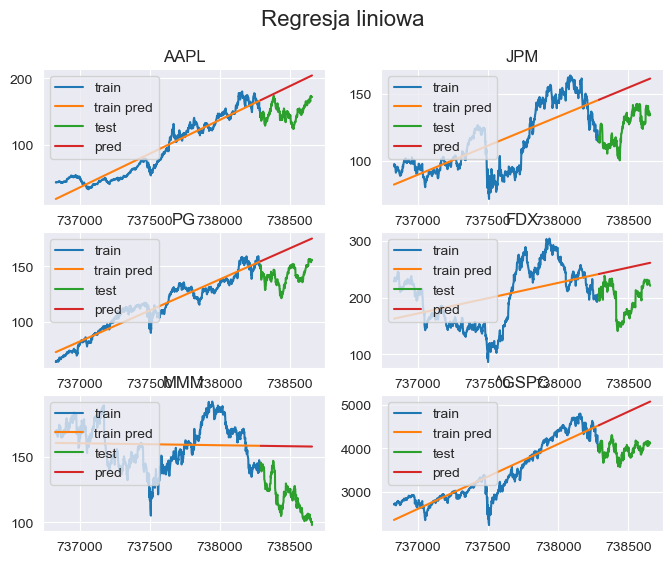

AAPL     JPM      PG      FDX      MMM      ^GSPC
R2     -9.80   -5.87   -8.69    -3.85    -9.23     -29.98
MSE  1473.33  921.39  607.13  3565.57  1626.55  736830.90
MAE    36.04   29.10   23.47    53.01    38.35     837.24

In [50]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

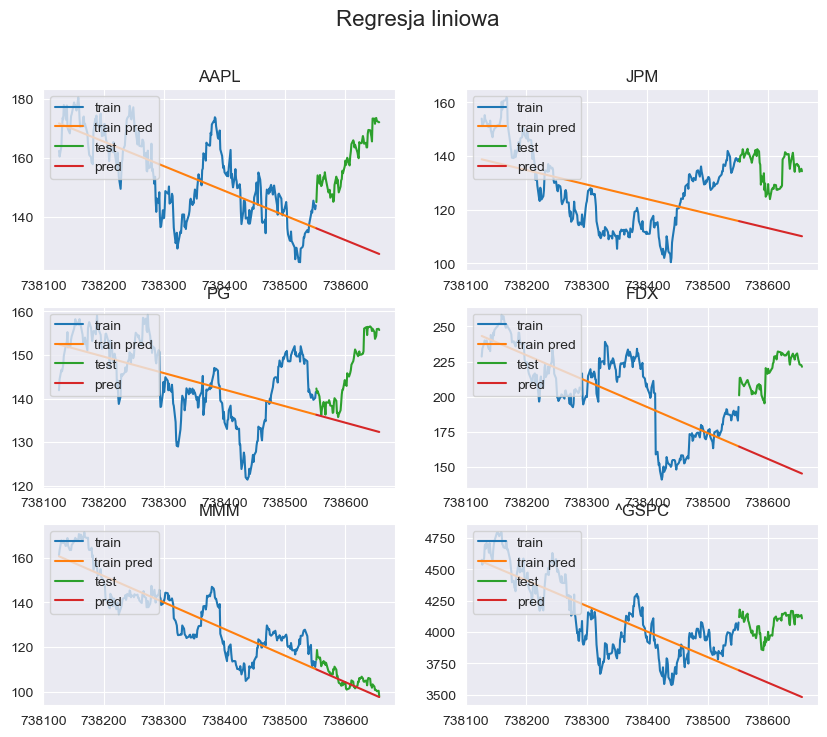

AAPL     JPM      PG      FDX    MMM      ^GSPC
R2   -11.41  -15.77   -2.92   -33.21   0.40     -32.94
MSE  853.39  533.12  200.67  4159.72  12.45  239635.15
MAE   27.20   22.43   11.53    62.53   2.99     474.86

In [12]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Regresja wielomianowa

In [13]:
def polynomial_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    poly_reg = PolynomialFeatures(degree=4)
    X_train_poly = poly_reg.fit_transform(X_train)
    X_test_poly = poly_reg.fit_transform(X_test)

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_train_pred = poly_reg.predict(X_train_poly)
    y_pred = poly_reg.predict(X_test_poly)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

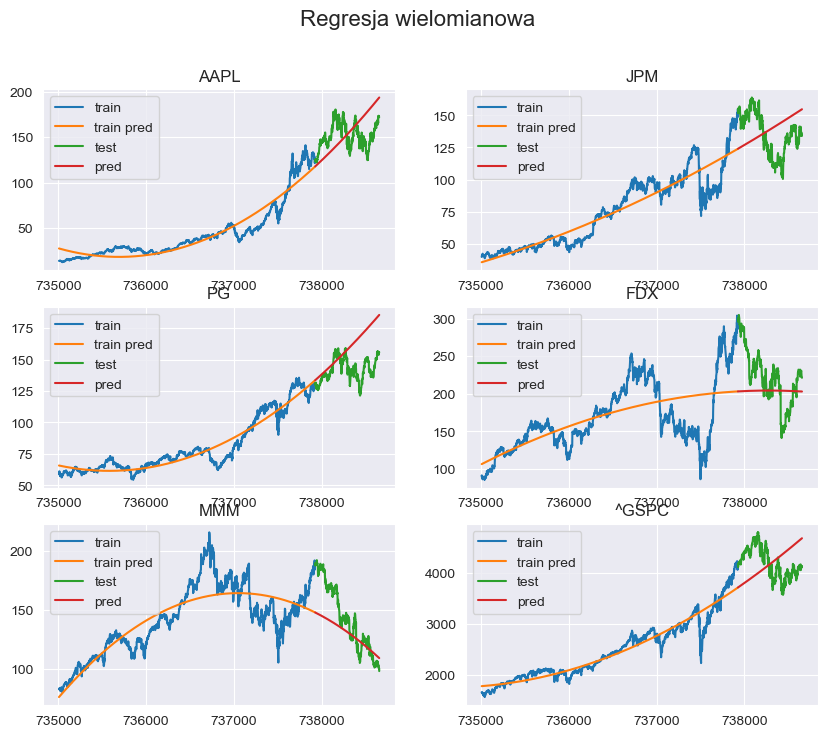

AAPL     JPM      PG      FDX     MMM      ^GSPC
R2    -2.13   -0.98   -5.41    -0.24    0.40      -2.20
MSE  571.86  507.21  499.99  1612.63  463.96  266014.15
MAE   21.18   20.81   17.44    31.74   16.77     481.44

In [14]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

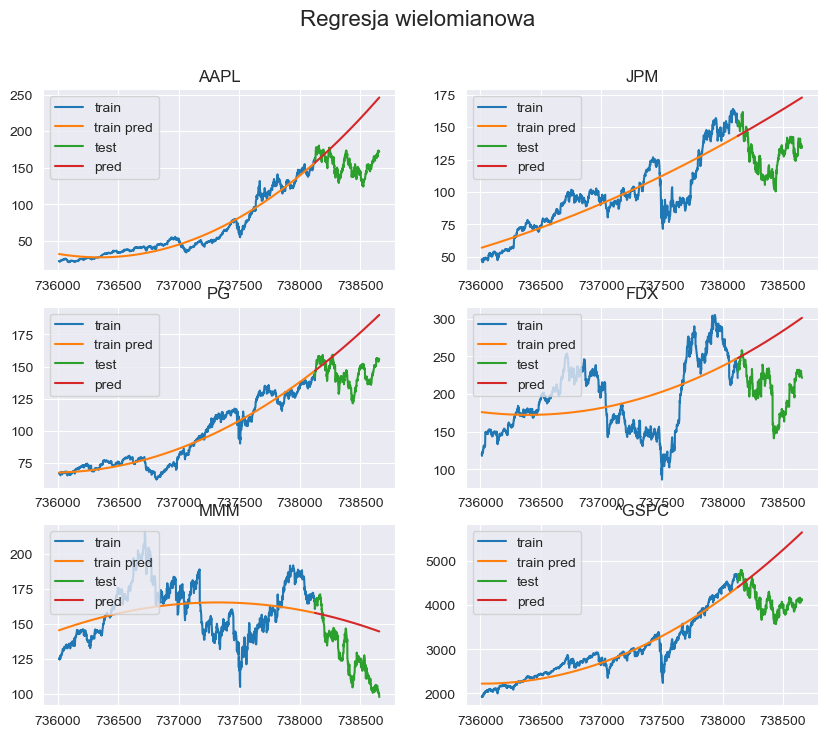

AAPL      JPM      PG      FDX     MMM       ^GSPC
R2    -16.85    -5.07  -10.07    -6.58   -1.04      -12.93
MSE  3079.34  1131.04  813.84  5701.38  753.99  1128051.93
MAE    47.28    30.62   24.29    66.56   24.37      931.77

In [15]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

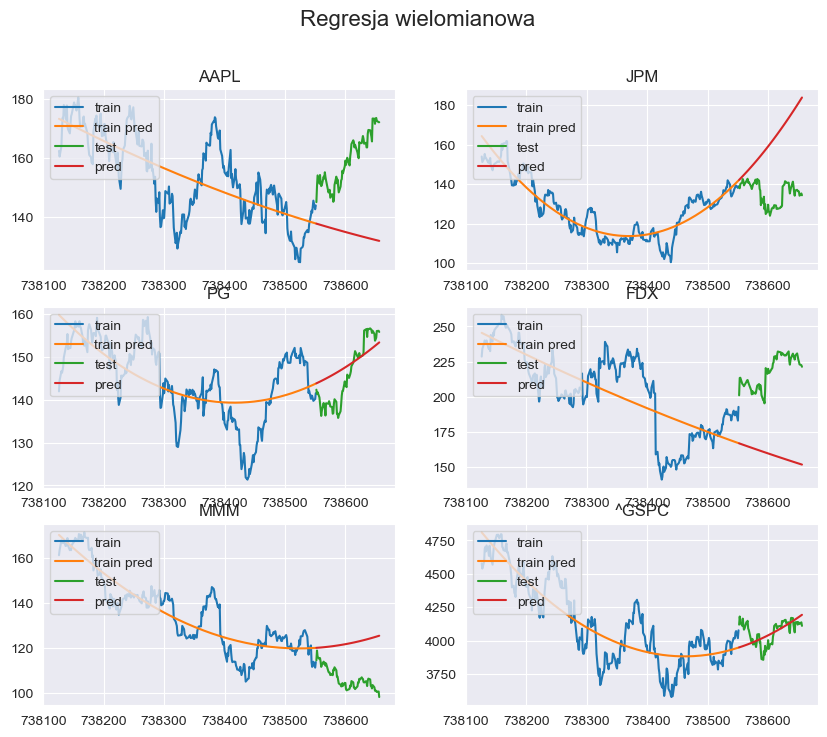

AAPL     JPM     PG      FDX     MMM    ^GSPC
R2    -8.99  -27.09   0.47   -28.77  -12.91    -0.12
MSE  686.70  892.98  27.17  3619.13  287.98  7894.60
MAE   24.27   26.13   4.35    58.32   15.94    68.96

In [16]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Support Vector Machine

In [17]:
def svm_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    svr = make_pipeline(StandardScaler(), SVR(C=2, epsilon=0.2))
    svr.fit(X_train, y_train)
    y_train_pred = svr.predict(X_train)
    y_pred = svr.predict(X_test)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

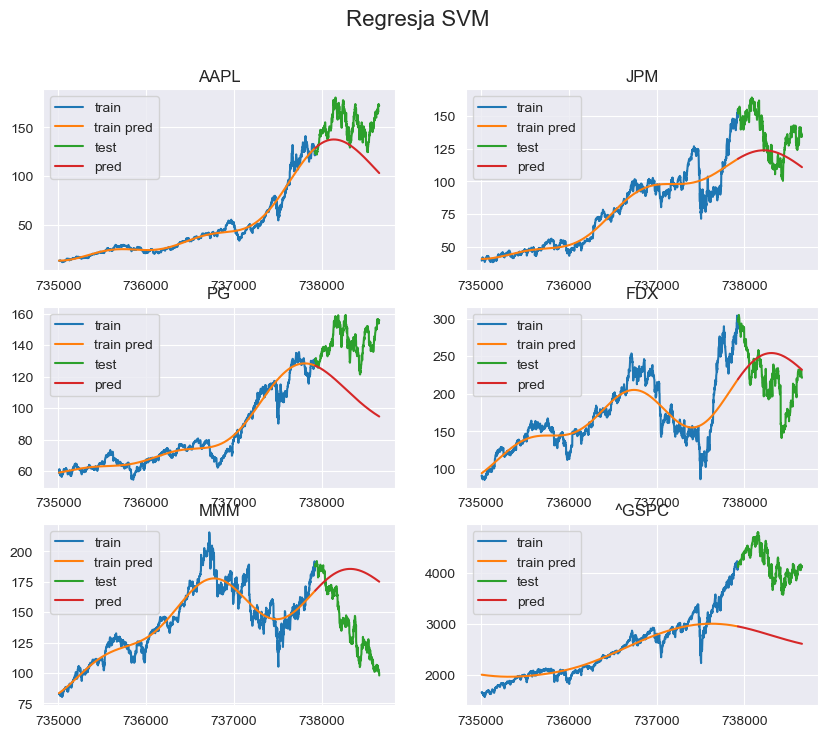

AAPL     JPM       PG      FDX      MMM       ^GSPC
R2    -3.63   -0.97   -14.02    -0.79    -2.02      -23.66
MSE  845.80  504.95  1170.79  2329.02  2315.16  2048072.43
MAE   24.49   19.54    30.79    39.85    41.62     1412.07

In [18]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

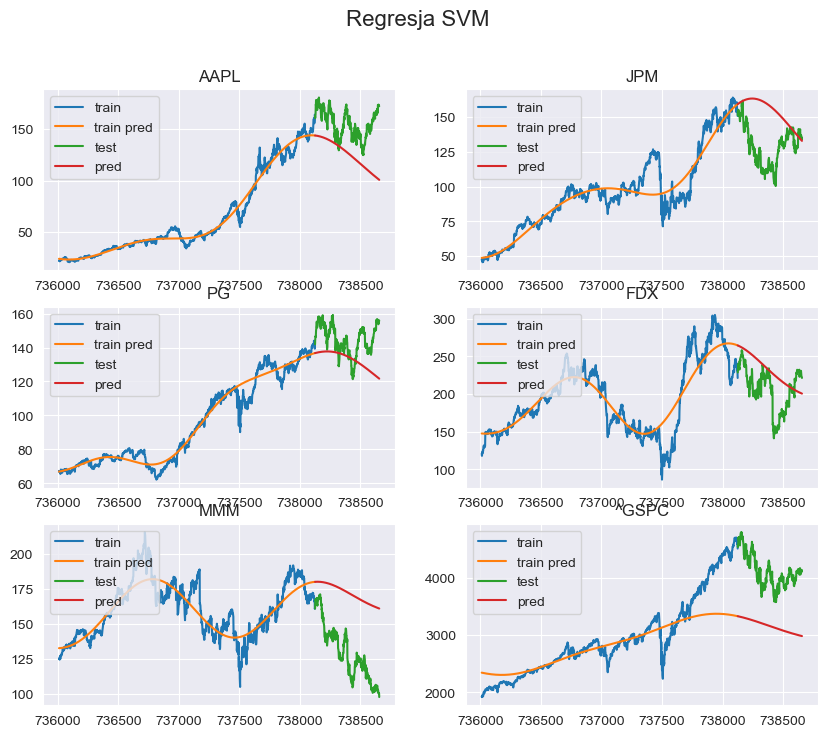

AAPL     JPM      PG      FDX      MMM      ^GSPC
R2     -5.43   -4.09   -2.16    -0.74    -4.44     -11.05
MSE  1109.39  947.28  232.60  1306.74  2015.50  975307.23
MAE    29.51   25.42   12.93    30.13    42.66     959.51

In [19]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

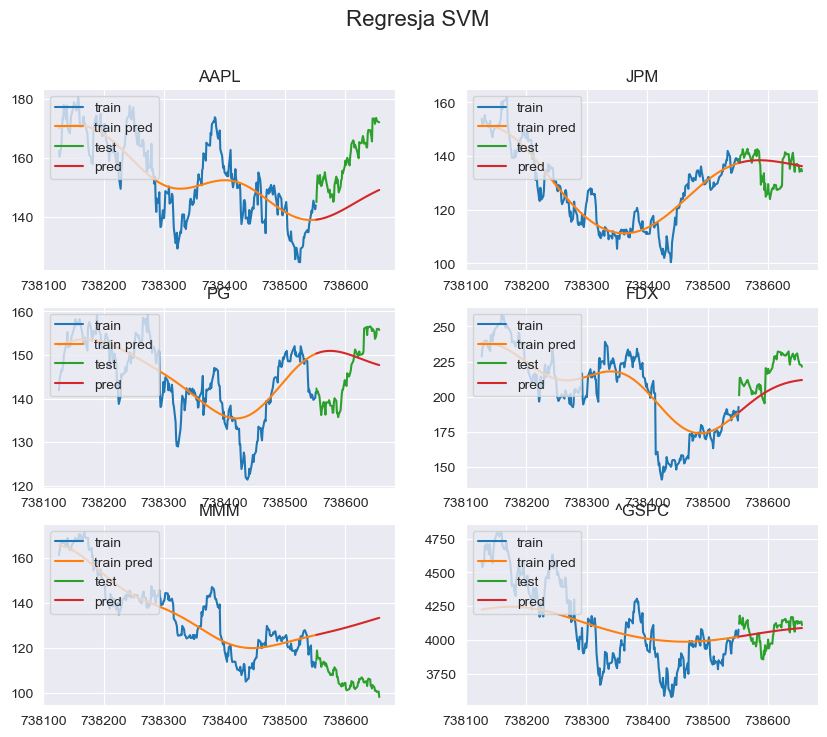

AAPL    JPM     PG     FDX     MMM    ^GSPC
R2    -2.88  -0.23  -0.61   -1.05  -26.97     0.07
MSE  267.03  39.21  82.73  249.44  579.14  6578.64
MAE   15.40   4.78   7.98   14.53   23.18    69.33

In [20]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Decision Tree Based Regression

In [21]:
def decision_tree_based_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    # y_train = y_train.ravel()
    # y_test = y_test.ravel()

    dt = DecisionTreeRegressor(max_depth=8)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_pred = dt.predict(X_test)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

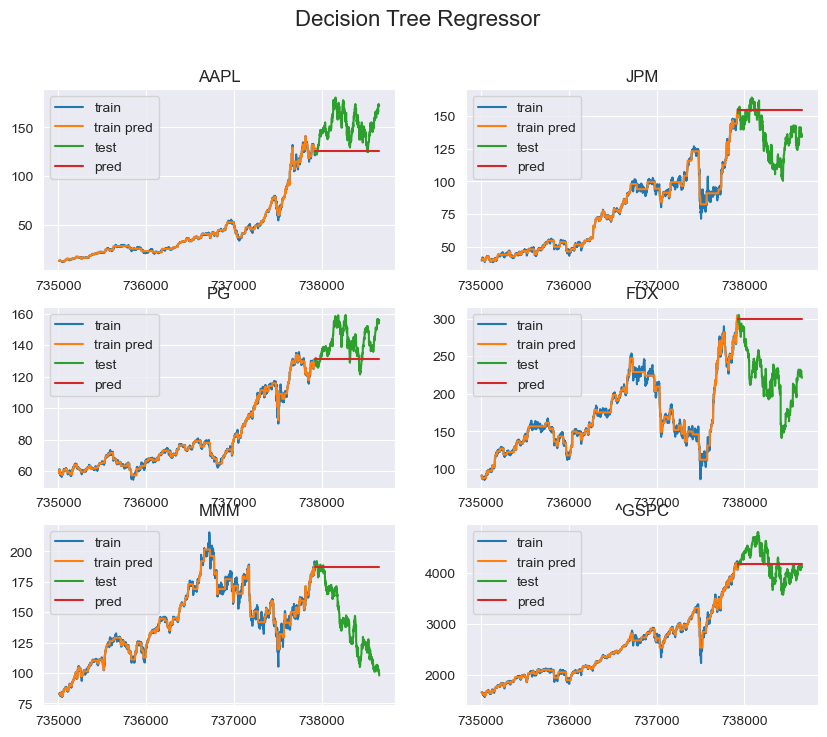

AAPL     JPM      PG      FDX      MMM     ^GSPC
R2    -3.57   -1.47   -1.45    -4.63    -2.52     -0.01
MSE  835.00  631.64  191.03  7340.63  2702.31  83752.30
MAE   25.67   20.47   11.56    77.77    44.17    243.50

In [22]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

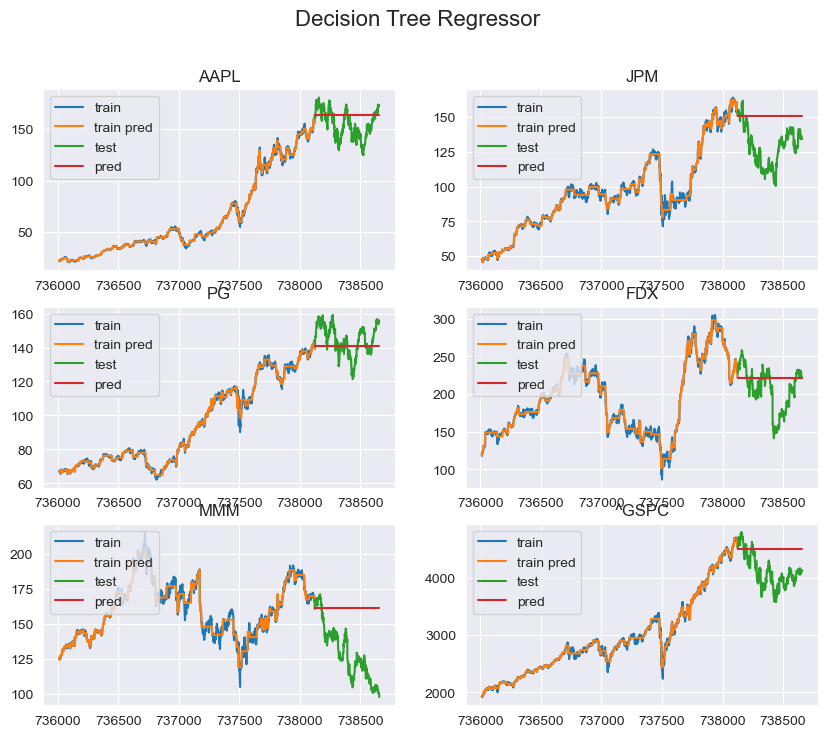

AAPL     JPM     PG     FDX      MMM      ^GSPC
R2    -0.40   -2.56  -0.18   -0.28    -2.77      -1.93
MSE  242.23  663.59  86.42  961.26  1397.12  237505.67
MAE   12.70   22.42   7.66   23.13    33.13     429.86

In [23]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

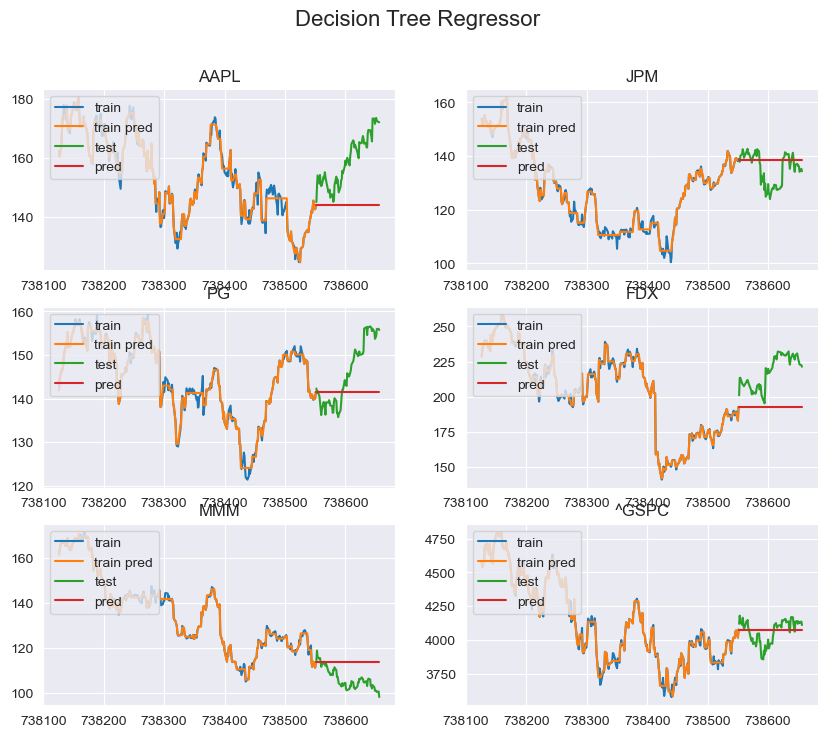

AAPL    JPM     PG     FDX    MMM    ^GSPC
R2    -3.32  -0.31  -0.36   -5.05  -2.68    -0.03
MSE  297.13  41.53  69.91  735.06  76.13  7255.36
MAE   15.11   4.94   6.76   24.77   7.77    70.80

In [24]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Model LSTM

In [25]:
def window_data(data, stock, n=3):
    windowed_data = pd.DataFrame()
    windowed_data['Target Date'] = data['Date']
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data[stock].shift(i)
    windowed_data['Target'] = data[stock] # Target is a value to be predicted, other columns are features
    return windowed_data.dropna()

def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0] # All rows, just the first column
    middle_matrix = df_as_np[:, 1:-1] # All but first and last columns
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1) # Reshape to 3D array
    y = df_as_np[:, -1] # Just the last column
    return dates, X.astype(np.float32), y.astype(np.float32)

In [26]:
df_lstm = pd.read_csv('data/close_prices_clean.csv', parse_dates=True)
df_lstm['Date'] = pd.to_datetime(df_lstm['Date'])

stocks_lstm = {}
for col in df_lstm.columns[1:]:
    stocks_lstm[col] = df_lstm[['Date', col]]

stocks_lstm['^GSPC'].head()

Date        ^GSPC
0 2013-05-20  1666.290039
1 2013-05-21  1669.160034
2 2013-05-22  1655.349976
3 2013-05-23  1650.510010
4 2013-05-24  1649.599976

In [27]:
def lstm_recursive_model(data, stock, ax):
    windowed_df = window_data(data, stock, n=10)
    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    test_split = int(len(X) * 0.8)

    dates_train, X_train, y_train = dates[:test_split], X[:test_split], y[:test_split]
    dates_test, X_test, y_test = dates[test_split:], X[test_split:], y[test_split:]

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    architecture_img_file = '/LSTM_model.png'
    plot_model(model, to_file=architecture_img_file, show_shapes=True, show_layer_names=True)
    model.fit(X_train, y_train, epochs=100, verbose=0)

    recursive_predictions = []
    recursive_dates = dates_test
    last_window = deepcopy(X_train[-1])

    for target_date in recursive_dates:
        next_prediction = model.predict(np.array([last_window])).flatten()
        recursive_predictions.append(next_prediction)
        new_window = list(last_window[1:])
        new_window.append(next_prediction)
        new_window = np.array(new_window)
        last_window = new_window

    y_train_pred = model.predict(X_train) 
    y_test_pred = model.predict(X_test)

    y_pred_naive = np.roll(y_test, 1)[1:]
    y_pred_naive = np.insert(y_pred_naive, 0, y_train[-1])


    ax.plot(dates_train, y_train, label='Train')
    ax.plot(dates_train, y_train_pred, label='Train Predictions')
    ax.plot(dates_test, y_test, label='Test')
    ax.plot(dates_test, y_test_pred, label='Test Predictions')
    ax.plot(recursive_dates, recursive_predictions, label='Recursive Predictions')
    ax.plot(dates_test, y_pred_naive, label='Naive Prediction')
    ax.legend(loc=2)
    ax.set_title(stock)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    results_df[stock] = evaluate_model(y_test, recursive_predictions)['Wartość']

### Wyniki dla ostatnich 10 lat

2023-05-18 20:16:30.301230: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 1ms/step


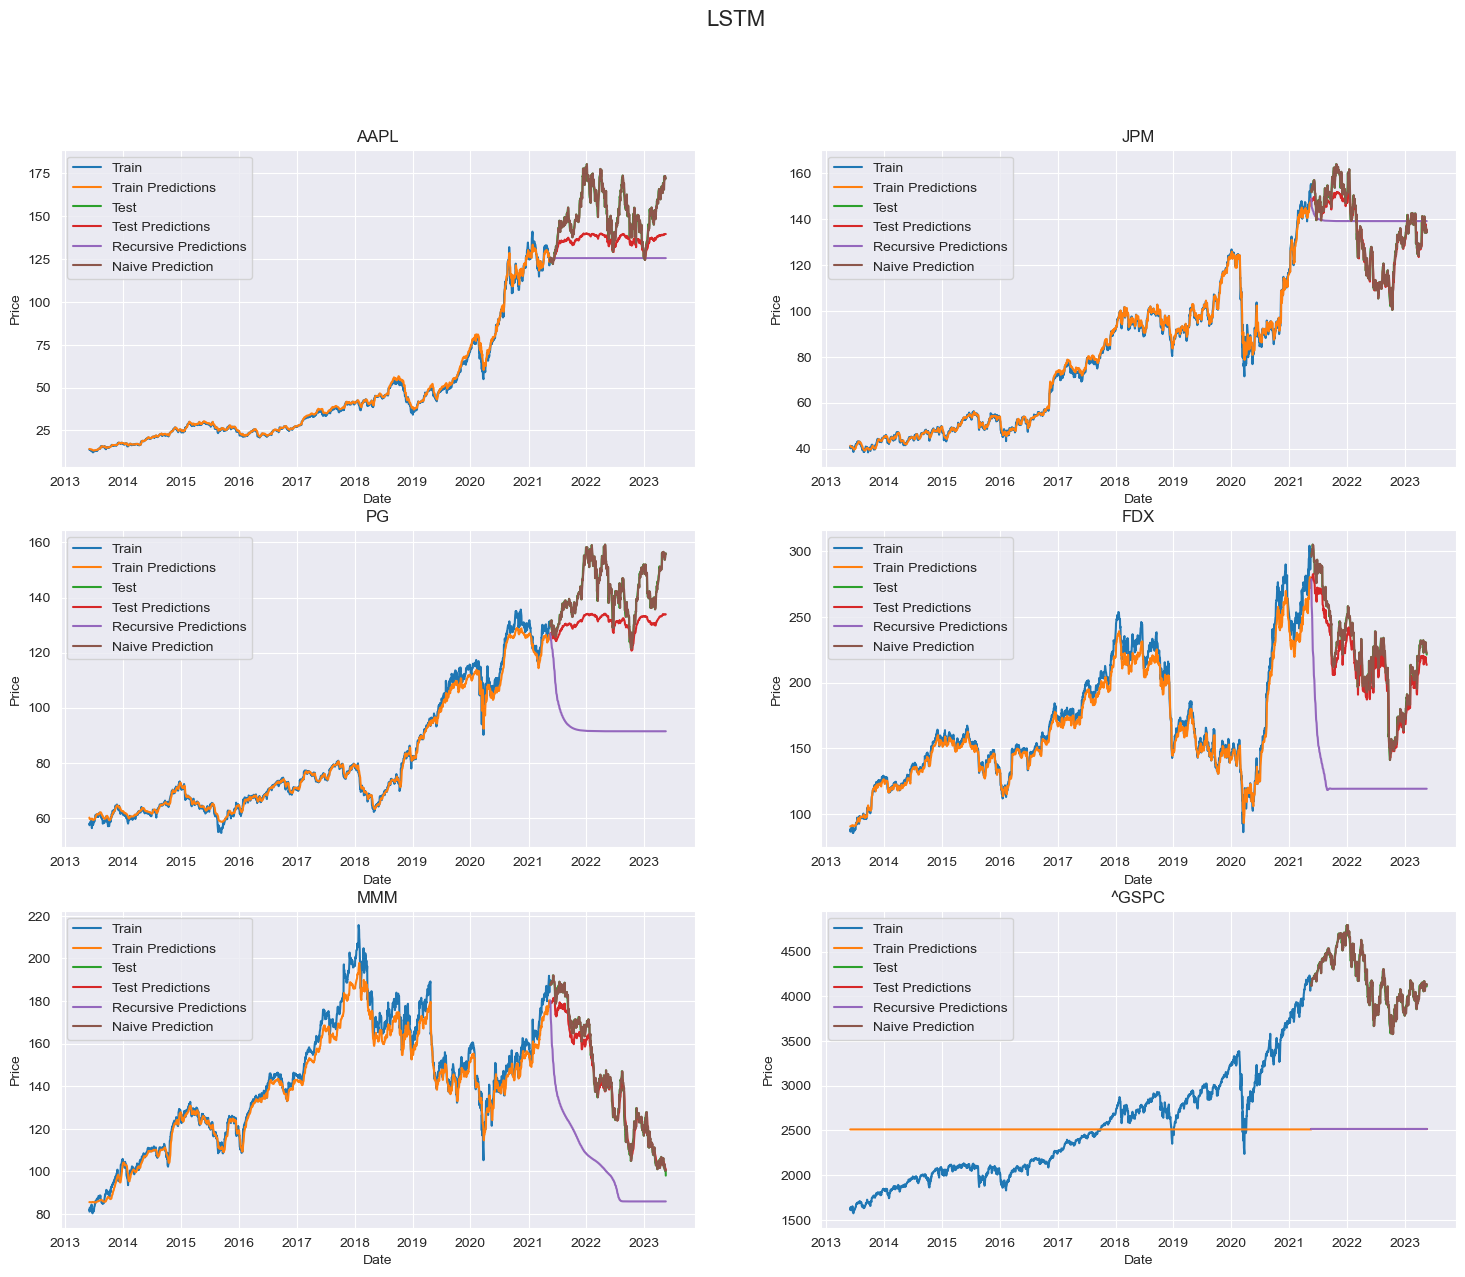

AAPL         JPM           PG           FDX          MMM  \
R2    -3.770000   -0.040000   -31.310000     -6.790000    -1.340000   
MSE  859.179993  265.880005  2511.219971  10009.950195  1780.849976   
MAE   26.139999   13.450000    48.470001     95.529999    40.110001   

            ^GSPC  
R2  -3.424000e+01  
MSE  2.937527e+06  
MAE  1.689430e+03

In [28]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock], stock, ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

12/12 [==============================] - 0s 1ms/step


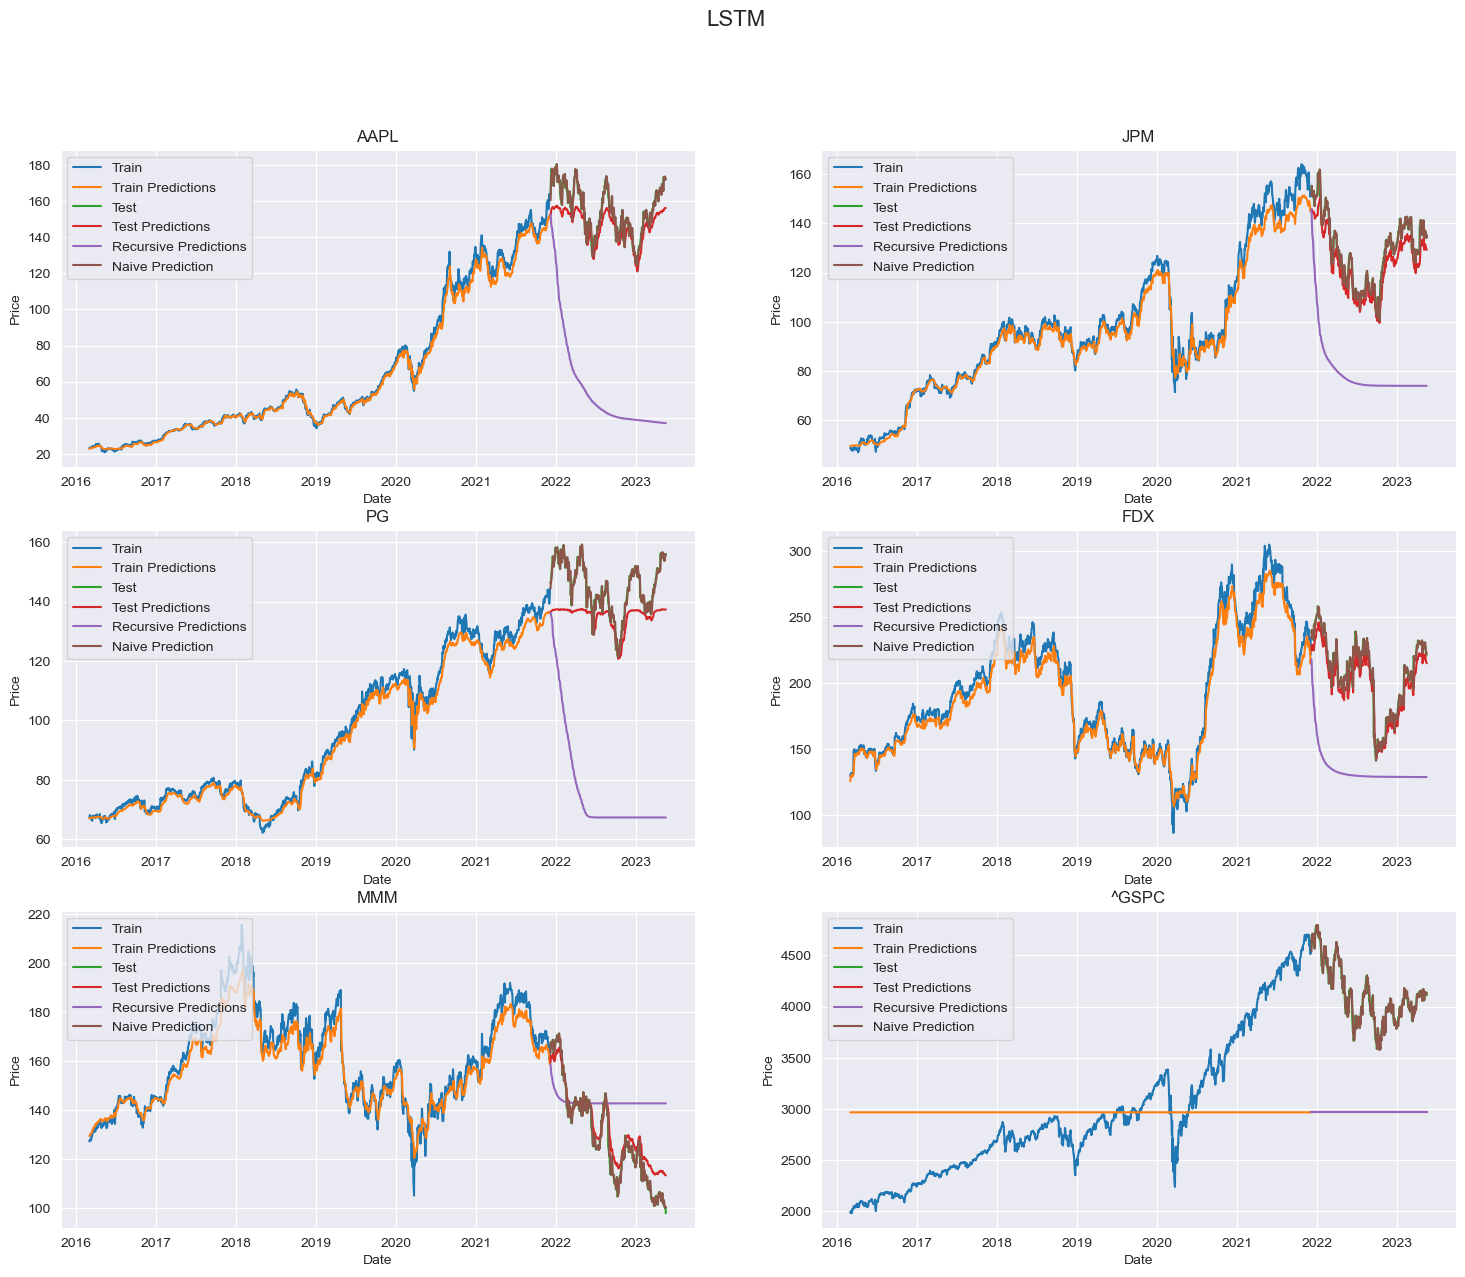

AAPL          JPM           PG          FDX         MMM  \
R2     -59.220000   -12.930000   -65.310000    -6.820000   -0.430000   
MSE  10431.440430  2565.959961  4898.379883  5891.629883  524.400024   
MAE     99.580002    49.189999    68.239998    72.610001   18.780001   

            ^GSPC  
R2  -1.643000e+01  
MSE  1.399834e+06  
MAE  1.148700e+03

In [29]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock][-last_5_years:], stock, ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

3/3 [==============================] - 0s 2ms/step


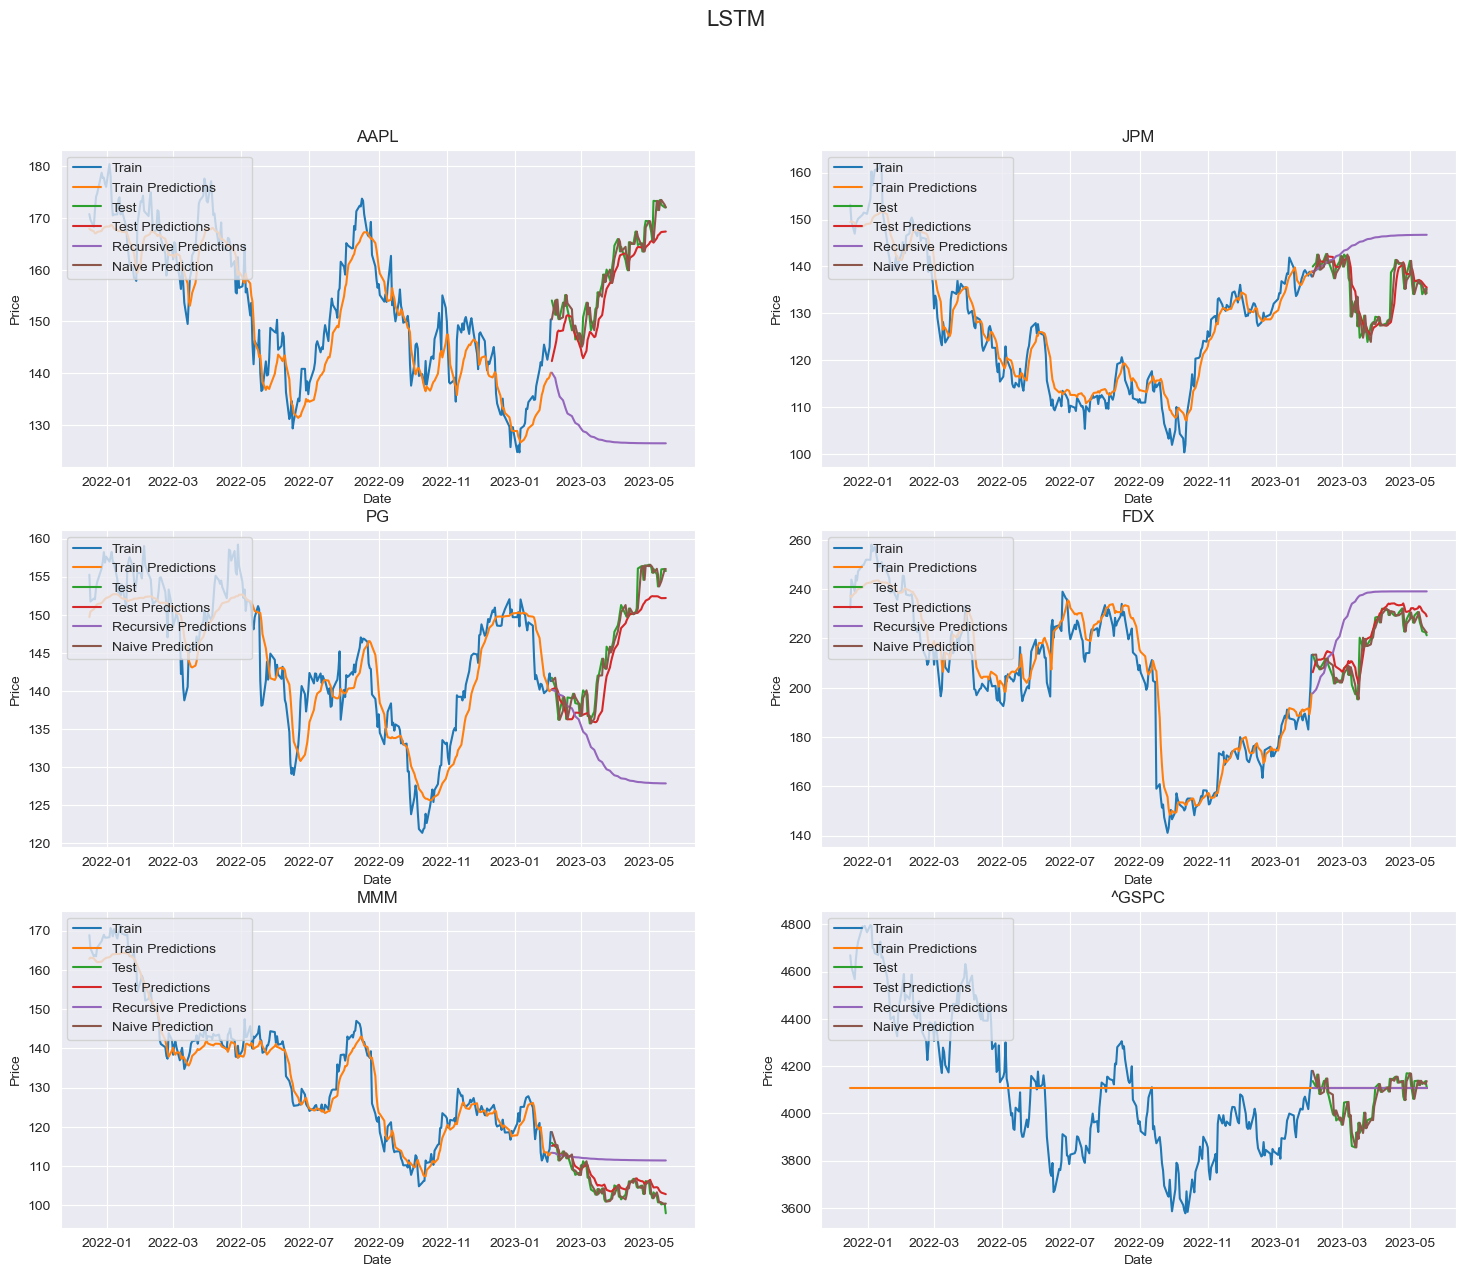

AAPL         JPM          PG         FDX    MMM        ^GSPC
R2    -14.790000   -3.320000   -5.210000   -1.320000  -1.85    -0.330000
MSE  1054.880005  140.309998  324.040009  280.049988  51.32  9354.860352
MAE    30.719999    9.750000   14.550000   14.500000   6.33    71.110001

In [30]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock][-last_year:], stock, ax)

plt.show()
results_df

# Prophet

In [31]:
df_prophet = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df_prophet.index = pd.DatetimeIndex(df_prophet.index)
stocks_prophet = {}
for col in df_prophet.columns:
    stocks_prophet[col] = df_prophet[[col]]


def prophet_model(data, ax):
    data = data.reset_index().rename(columns={'Date':'ds', data.columns[0]:'y'})
    X_train, X_test, y_train, y_test = train_test_split(data, data.y, test_size=test_size, shuffle=False)
    m = Prophet(daily_seasonality=True)
    m.fit(X_train)

    future = m.make_future_dataframe(periods=len(X_test)) #we need to specify the number of days in future
    y_pred = m.predict(future)
    y_pred_values = y_pred[['ds', 'yhat']].set_index('ds') # for evaluation

    ax.plot(X_train.ds, y_train, label='train')
    ax.plot(X_test.ds, y_test, label='test')
    m.plot(y_pred, ax=ax)
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred_values.yhat[-len(y_test):].values)['Wartość']

### Wyniki dla ostatnich 10 lat

20:25:34 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:37 - cmdstanpy - INFO - Chain [1] start processing
20:25:37 - cmdstanpy - INFO - Chain [1] done processing
20:25:38 - cmdstanpy - INFO - Chain [1] start processing
20:25:38 - cmdstanpy - INFO - Chain [1] done processing
20:25:39 - cmdstanpy - INFO - Chain [1] start processing
20:25:39 - cmdstanpy - INFO - Chain [1] done processing
20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


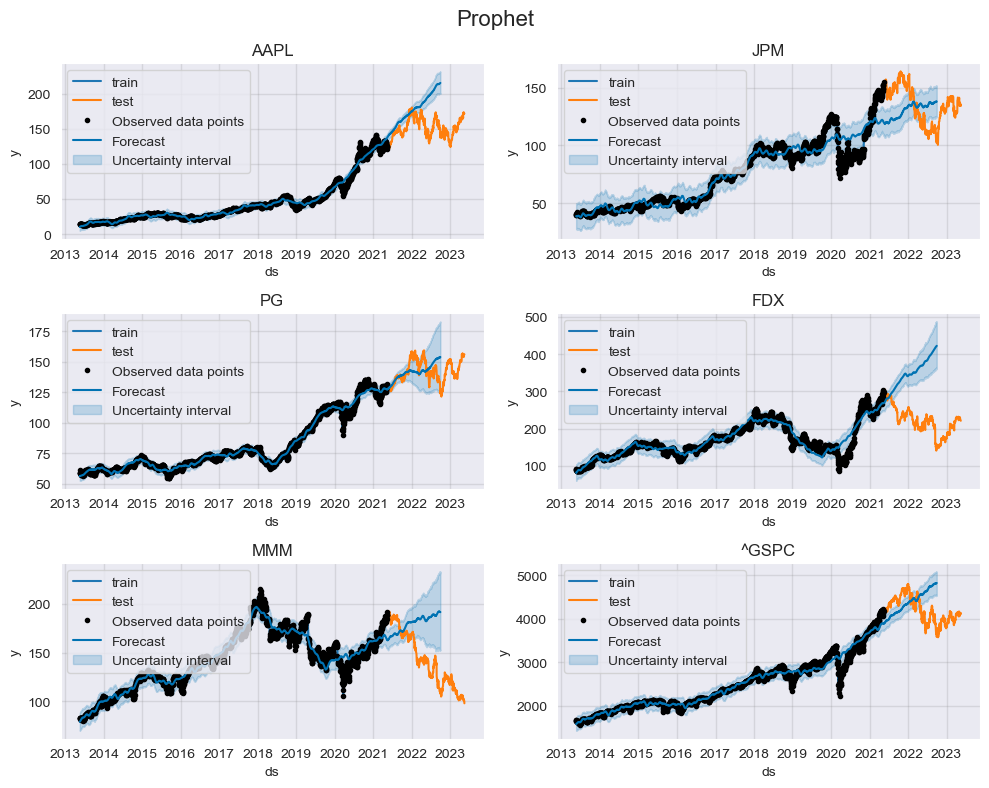

AAPL     JPM     PG       FDX      MMM      ^GSPC
R2     -5.53   -0.85   0.17    -14.62    -2.39      -2.41
MSE  1191.13  472.76  64.34  20353.26  2604.20  283019.00
MAE    27.12   18.04   6.17    126.95    42.59     479.79

In [32]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:42 - cmdstanpy - INFO - Chain [1] done processing
20:25:42 - cmdstanpy - INFO - Chain [1] start processing
20:25:43 - cmdstanpy - INFO - Chain [1] done processing
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing
20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing
20:25:45 - cmdstanpy - INFO - Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing
20:25:46 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


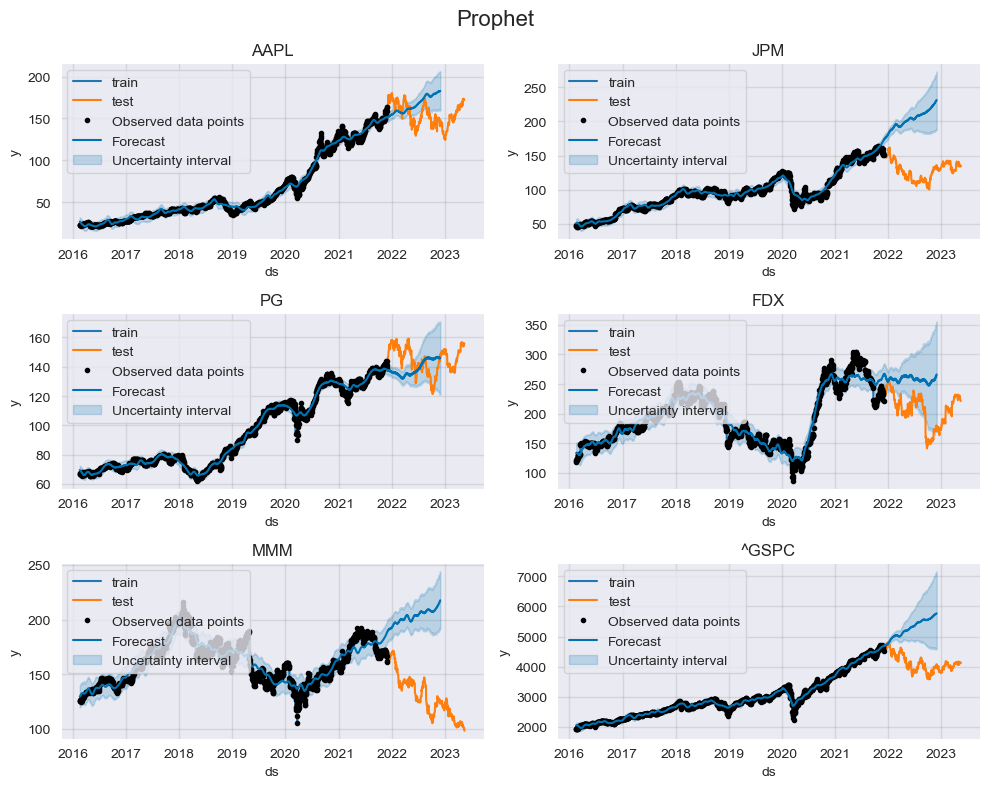

AAPL      JPM      PG      FDX      MMM       ^GSPC
R2    -1.82   -30.32   -0.76    -3.48   -15.14      -18.66
MSE  487.22  5832.88  129.18  3369.09  5977.02  1591817.51
MAE   18.72    73.39    9.43    51.55    73.18     1145.61

In [33]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
20:25:48 - cmdstanpy - INFO - Chain [1] start processing
20:25:48 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing
20:25:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:49 - cmdstanpy - INFO - Chain [1] done processing


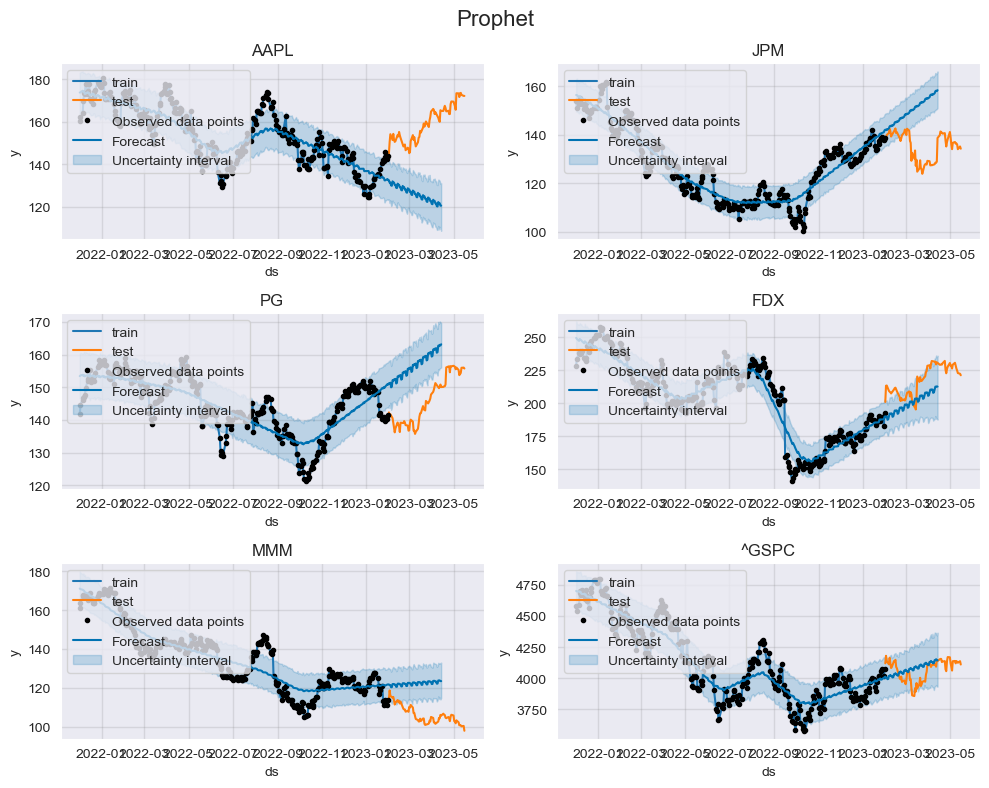

AAPL     JPM      PG     FDX     MMM    ^GSPC
R2    -16.72   -7.99   -1.65   -1.87  -12.92     0.03
MSE  1218.35  285.67  135.58  349.50  288.24  6882.11
MAE    32.99   14.72   10.87   17.34   16.19    65.09

In [34]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock][-last_year:], ax)

plt.show()
results_df

# ARIMA

In [86]:
def arima_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)

    model = pm.auto_arima(y_train, error_action='ignore', trace=True, suppress_warnings=True, maxiter=50, seasonal=False)
    model.fit(y_train)

    y_pred, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True)
    y_pred_values = pd.DataFrame(y_pred, index=X_test, columns=['yhat'])

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='predictions')
    ax.fill_between(X_test, conf_int[:, 0], conf_int[:, 1], alpha=0.3)
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred_values.yhat.values)['Wartość']    

### Wyniki dla ostatnich 10 lat

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6250.551, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6270.456, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6246.346, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6247.846, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6273.193, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6246.938, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6246.555, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6248.547, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6250.258, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7074.188, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7135.351, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7103.140, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=710

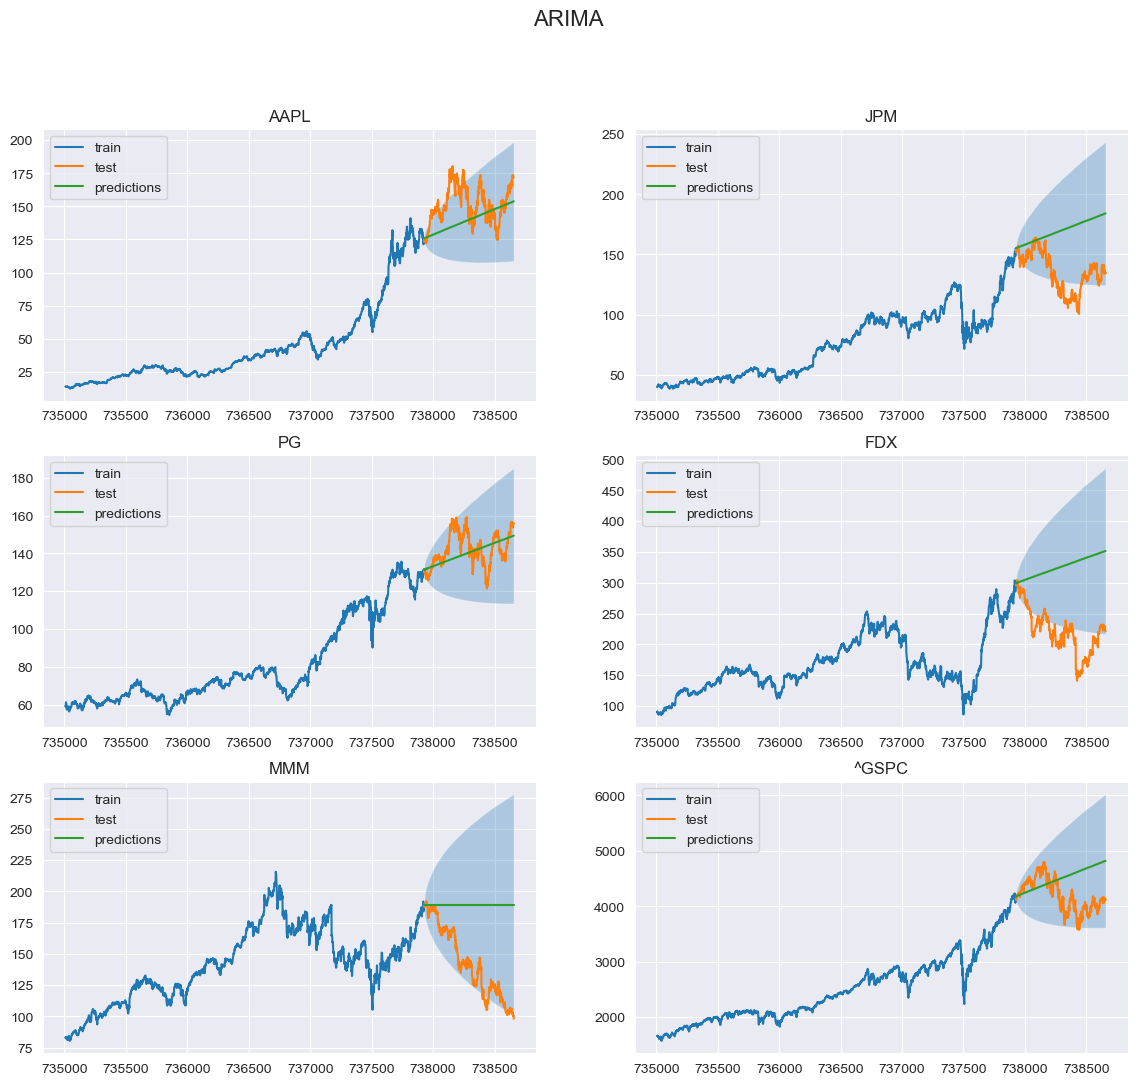

AAPL      JPM     PG       FDX      MMM      ^GSPC
R2    -0.90    -5.44  -0.05     -9.14    -2.75      -2.32
MSE  346.47  1648.68  82.17  13214.16  2882.11  276112.80
MAE   14.86    34.33   6.97    104.51    46.01     432.70

In [87]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4312.935, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4310.957, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4307.599, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4307.523, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4311.389, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4309.436, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4309.484, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4311.440, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4308.348, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.880 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4364.229, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4394.692, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4390.630, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=439

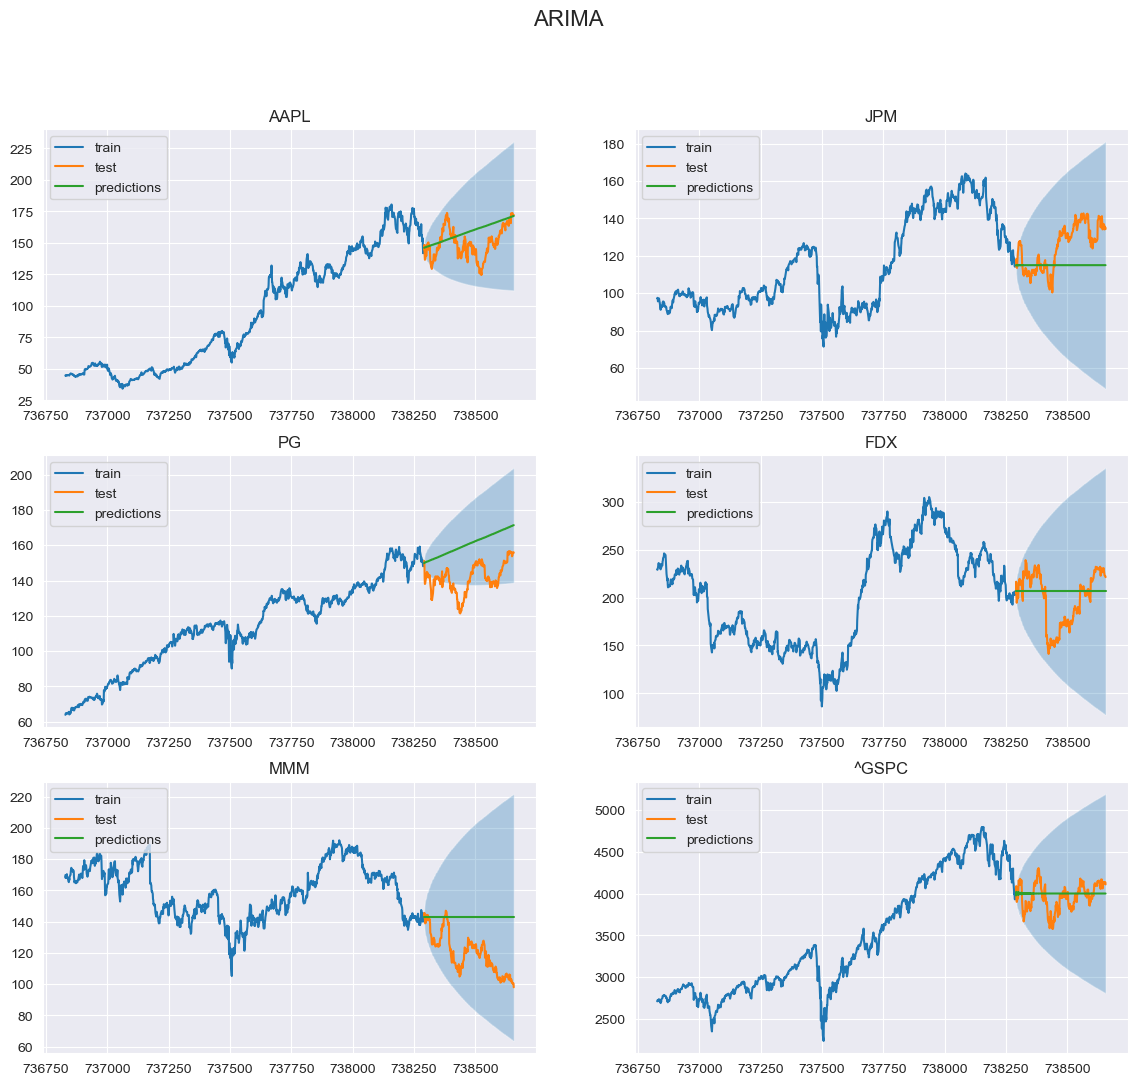

AAPL     JPM      PG     FDX     MMM     ^GSPC
R2    -0.58   -0.69   -5.85   -0.08   -3.32     -0.05
MSE  215.39  226.75  429.02  792.27  687.29  25074.00
MAE   11.88   12.56   19.28   22.89   23.16    127.33

In [88]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1034.220, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1034.332, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1036.222, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1036.196, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1032.350, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1037.427, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.224 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=852.367, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=846.797, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=847.189, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=847.176, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=845.792, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=849.175, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tota

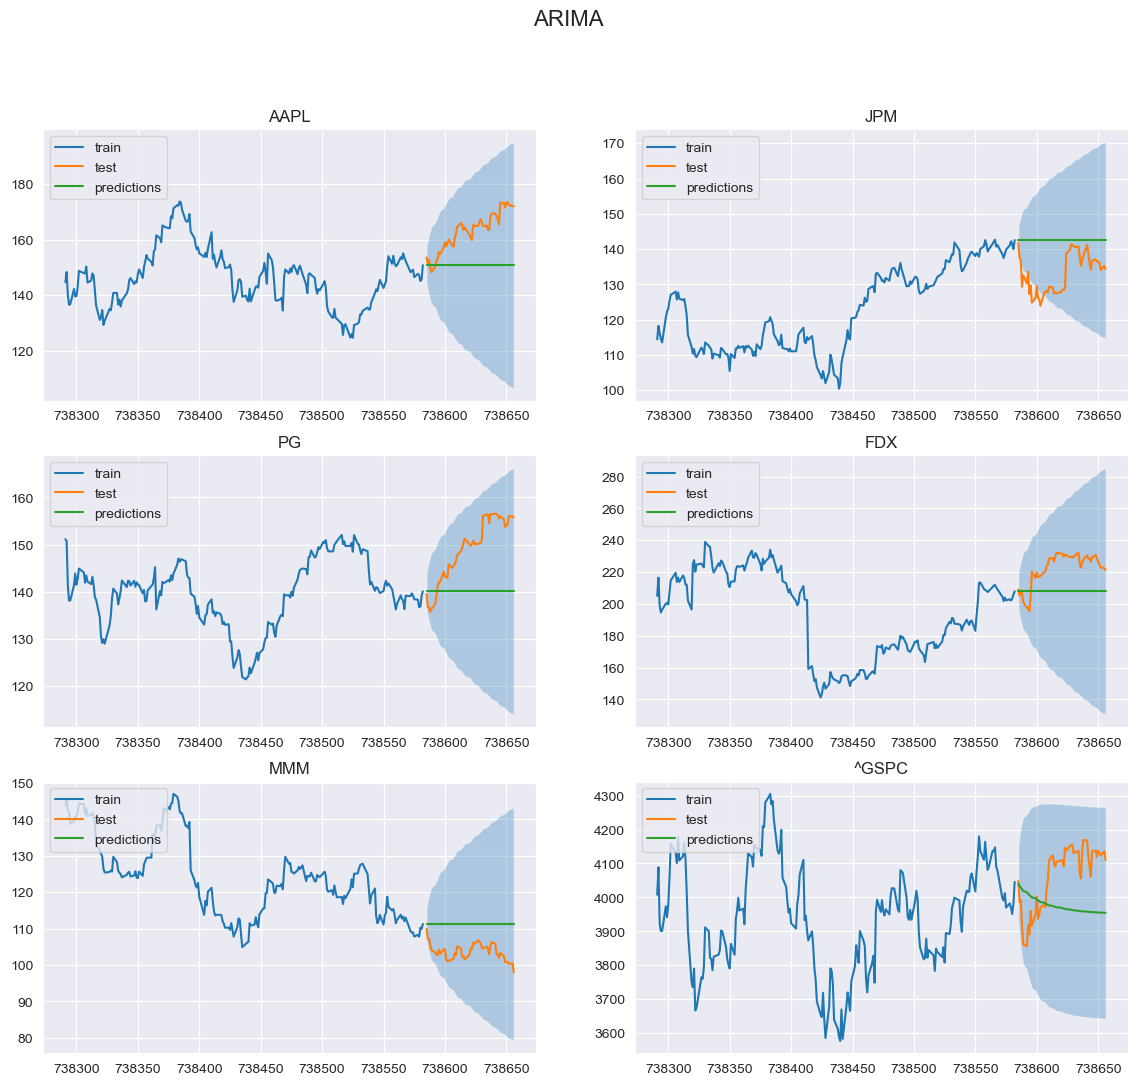

AAPL     JPM      PG     FDX    MMM     ^GSPC
R2    -3.05   -3.14   -1.82   -1.97 -12.15     -1.36
MSE  189.64  116.90  118.74  300.21  63.51  18631.30
MAE   12.09    9.42    9.51   15.99   7.66    122.53

In [89]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Naive Model - prognozowanie ostatniej występującej w zbiorze treningowym wartości

In [92]:
def naive_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    y_pred = np.full(len(y_test), y_train[-1]) # predicts last value from train set

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='predictions')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']


### Wyniki dla ostatnich 10 lat

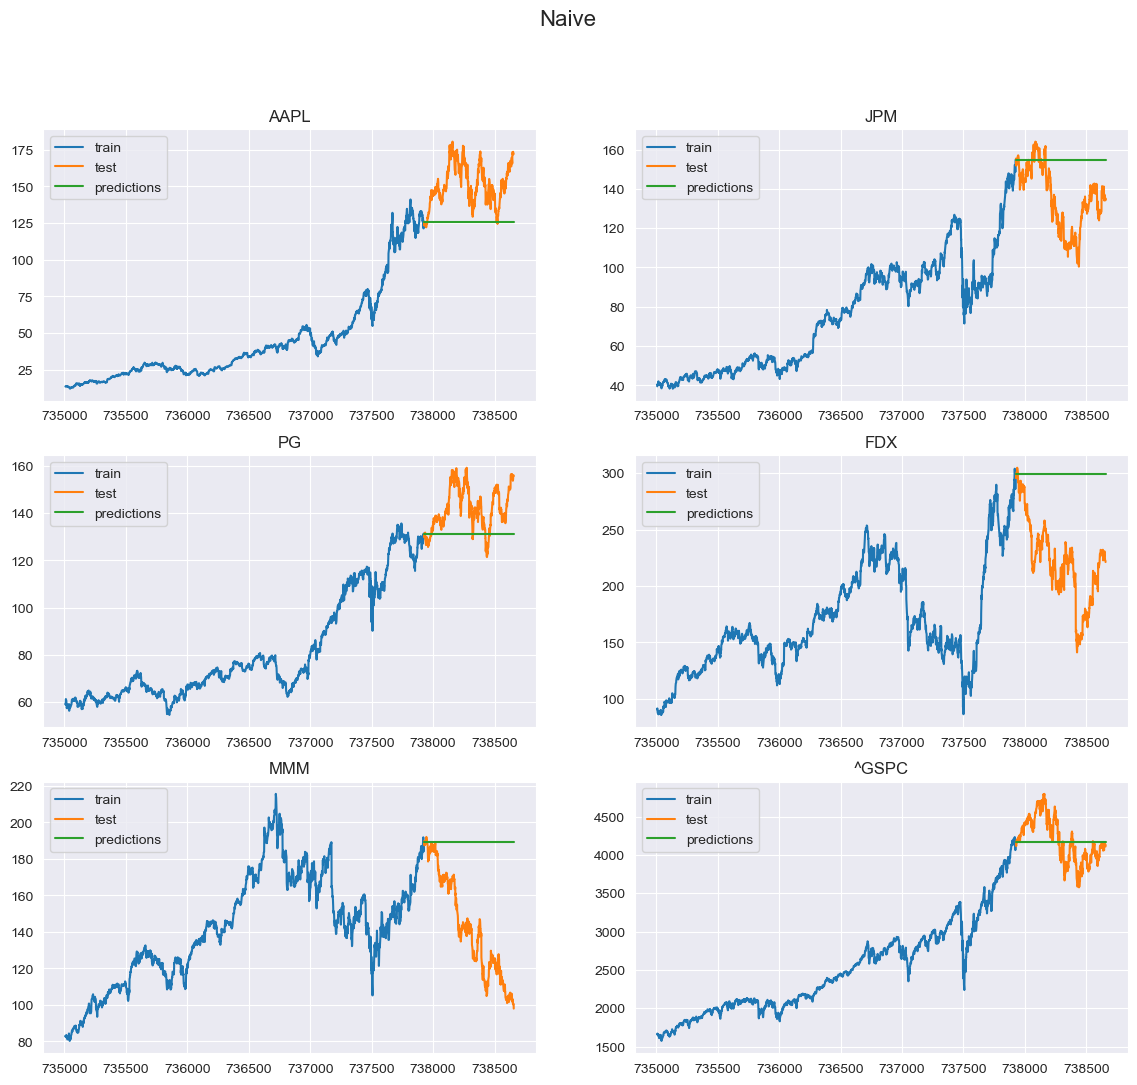

AAPL     JPM      PG      FDX      MMM     ^GSPC
R2    -3.57   -1.47   -1.45    -4.63    -2.75     -0.01
MSE  835.00  631.64  191.03  7340.63  2882.11  83752.30
MAE   25.67   20.47   11.56    77.77    46.01    243.50

In [94]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

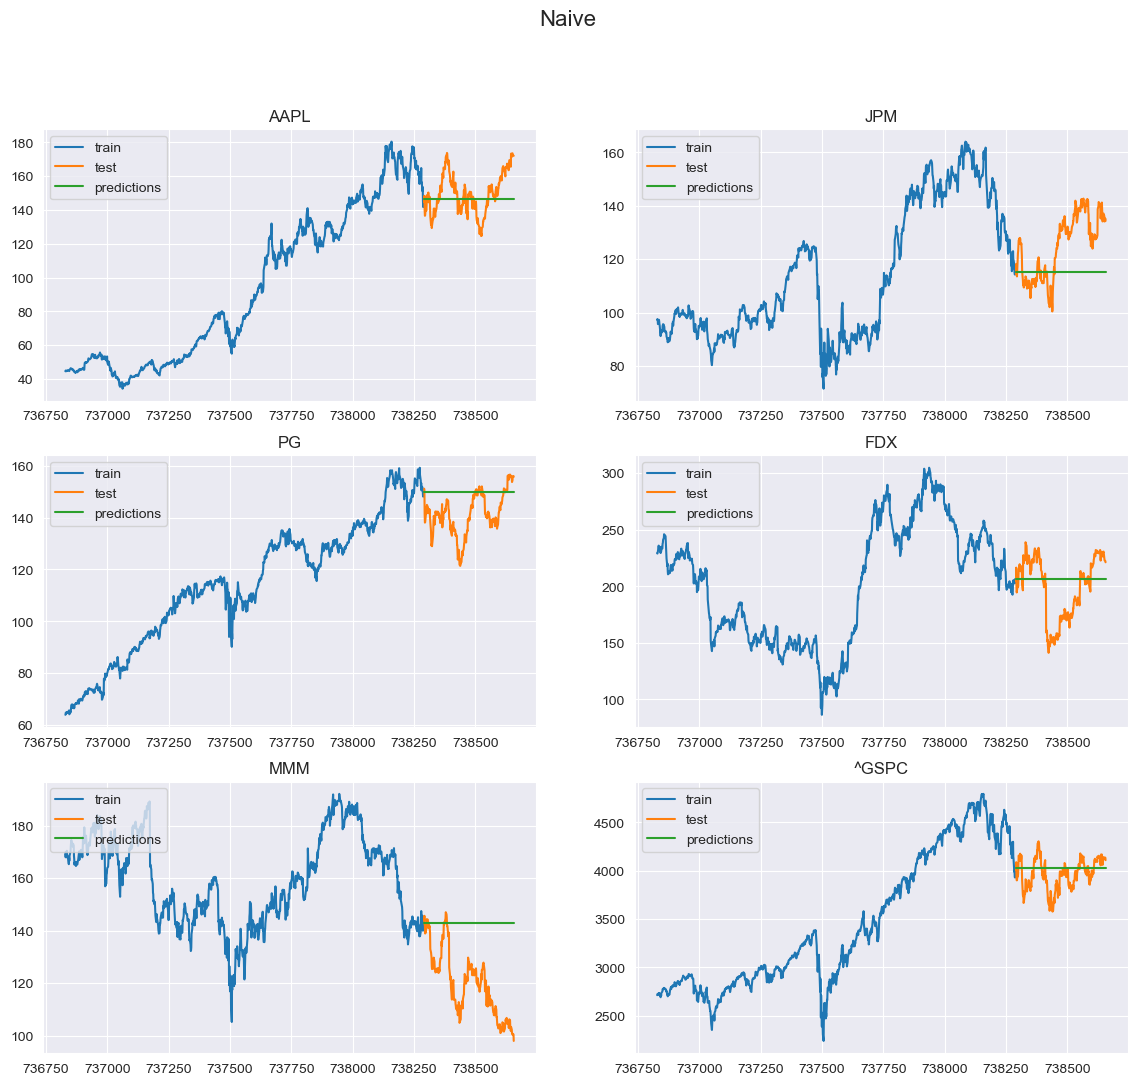

AAPL     JPM      PG     FDX     MMM     ^GSPC
R2    -0.10   -0.66   -1.10   -0.08   -3.32     -0.15
MSE  149.58  222.69  131.32  792.27  687.29  27270.07
MAE    9.73   12.49    9.32   22.89   23.16    132.46

In [93]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

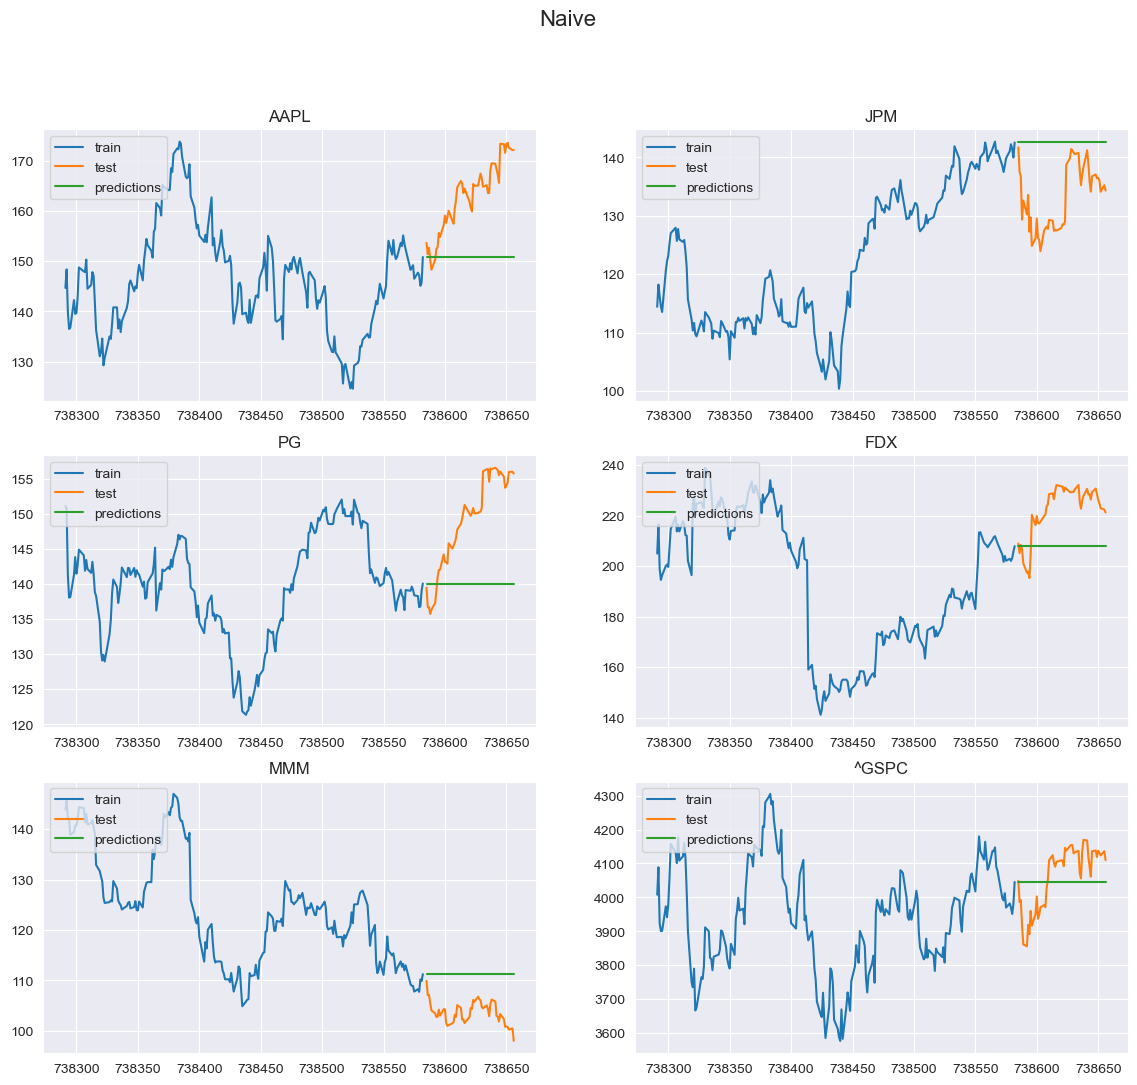

AAPL     JPM      PG     FDX    MMM    ^GSPC
R2    -3.05   -3.14   -1.82   -1.97 -12.15    -0.03
MSE  189.64  116.90  118.74  300.21  63.51  8096.53
MAE   12.09    9.42    9.51   15.99   7.66    80.83

In [95]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock][-last_year:], ax)

plt.show()
results_df